<a href="https://colab.research.google.com/github/sanchitgulati/fluidSim/blob/main/fluidSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [208]:
import numpy as np
import math
from matplotlib import pyplot as plt

In [209]:
overRelaxation = 1.0 # 1.9

In [210]:
U_FIELD = 0;
V_FIELD = 1;
S_FIELD = 2;

In [211]:
class Fluid:
    def __init__(self, density, numX, numY, h):
        self.density = density
        self.numX = numX + 2
        self.numY = numY + 2
        self.h = h
        self.u = np.empty((self.numX,self.numY), dtype=np.float32)
        self.v = np.empty((self.numX,self.numY), dtype=np.float32)
        self.newU = np.empty((self.numX,self.numY), dtype=np.float32)
        self.newV = np.empty((self.numX,self.numY), dtype=np.float32)
        self.p = np.empty((self.numX,self.numY), dtype=np.float32)
        self.s = np.empty((self.numX,self.numY), dtype=np.float32)
        self.m = np.empty((self.numX,self.numY), dtype=np.float32)
        self.newM = np.empty((self.numX,self.numY), dtype=np.float32)
        self.m.fill(1.0)
        num = numX * numY

    def integrate(self, dt, gravity):
        n = self.numY
        for i in range(1, self.numX):
            for j in range(1, self.numY-1):
                if self.s[i][j] != 0.0 and self.s[i][j-1] != 0.0:
                    self.v[i][j] += gravity * dt



    def solveIncompressibility(self, numIters, dt):
        cp = self.density * self.h / dt

        for iter in range(numIters):
            for i in range(1, self.numX - 1):
                for j in range(1, self.numY - 1):
                    if self.s[i][j] == 0.0:
                        continue
                    s = self.s[i][j]
                    sx0 = self.s[(i - 1)][j]
                    sx1 = self.s[(i + 1)][j]
                    sy0 = self.s[i][j - 1]
                    sy1 = self.s[i][j + 1]
                    s = sx0 + sx1 + sy0 + sy1
                    if s == 0.0:
                        continue
                    div = (
                        self.u[(i + 1)][j]
                        - self.u[i][j]
                        + self.v[i][j + 1]
                        - self.v[i][j]
                    )
                    p = -div / s
                    p *= overRelaxation
                    self.p[i][j] += cp * p
                    self.u[i][j] -= sx0 * p
                    self.u[(i + 1)][j] += sx1 * p
                    self.v[i][j] -= sy0 * p
                    self.v[i][j + 1] += sy1 * p

    def extrapolate(self):
        n = self.numY
        for i in range(self.numX):
            self.u[i][0] = self.u[i][1]
            self.u[i][self.numY - 1] = self.u[i][self.numY - 2]
        for j in range(self.numY):
            self.v[0][j] = self.v[1][j]
            self.v[(self.numX - 1)][j] = self.v[(self.numX - 2)][j]

    def sampleField(self, x, y, field):
        n = self.numY
        h = self.h
        h1 = 1.0 / h
        h2 = 0.5 * h

        x = max(min(x, self.numX * h), h)
        y = max(min(y, self.numY * h), h)

        dx = 0.0
        dy = 0.0

        f = None

        if field == U_FIELD:
            f = self.u
            dy = h2
        elif field == V_FIELD:
            f = self.v
            dx = h2
        elif field == S_FIELD:
            f = self.m
            dx = h2
            dy = h2

        x0 = min(math.floor((x - dx) * h1), self.numX - 1)
        tx = ((x - dx) - x0 * h) * h1
        x1 = min(x0 + 1, self.numX - 1)

        y0 = min(math.floor((y - dy) * h1), self.numY - 1)
        ty = ((y - dy) - y0 * h) * h1
        y1 = min(y0 + 1, self.numY - 1)

        sx = 1.0 - tx
        sy = 1.0 - ty

        val = (
            sx * sy * f[x0][y0]
            + tx * sy * f[x1][y0]
            + tx * ty * f[x1][y1]
            + sx * ty * f[x0][y1]
        )

        return val

    def avgU(self, i, j):
        n = self.numY
        u = (
            self.u[i][j - 1]
            + self.u[i][j]
            + self.u[(i + 1)][j - 1]
            + self.u[(i + 1)][j]
        ) * 0.25
        return u

    def avgV(self, i, j):
        n = self.numY
        v = (
            self.v[(i - 1)][j]
            + self.v[i][j]
            + self.v[(i - 1)][j + 1]
            + self.v[i][j + 1]
        ) * 0.25
        return v

    def advectVel(self, dt):
        self.newU = self.u.copy()
        self.newV = self.v.copy()

        n = self.numY
        h = self.h
        h2 = 0.5 * h

        for i in range(1, self.numX):
            for j in range(1, self.numY):
                # u component
                if (self.s[i][j] != 0.0 and self.s[(i - 1)][j] != 0.0 and j < self.numY - 1):
                    x = i * h
                    y = j * h + h2
                    u = self.u[i][j]
                    v = self.avgV(i, j)
                    x = x - dt * u
                    y = y - dt * v
                    u = self.sampleField(x, y, U_FIELD)
                    self.newU[i][j] = u
                # v component
                if (self.s[i][j] != 0.0 and self.s[i][j - 1] != 0.0 and i < self.numX - 1):
                    x = i * h + h2
                    y = j * h
                    u = self.avgU(i, j)
                    v = self.v[i][j]
                    x = x - dt * u
                    y = y - dt * v
                    v = self.sampleField(x, y, V_FIELD)
                    self.newV[i][j] = v

        self.u = self.newU.copy()
        self.v = self.newV.copy()

    def advectSmoke(self, dt):
        self.newM = self.m.copy()
        h = self.h
        h2 = 0.5 * h

        for i in range(1, self.numX - 1):
            for j in range(1, self.numY - 1):
                if self.s[i][j] != 0.0:
                    u = (self.u[i][j] + self.u[(i + 1)][j]) * 0.5
                    v = (self.v[i][j] + self.v[i][j + 1]) * 0.5
                    x = i * h + h2 - dt * u
                    y = j * h + h2 - dt * v
                    self.newM[i][j] = self.sampleField(x, y, S_FIELD)

        self.m = self.newM.copy()

    def simulate(self, dt, gravity, numIters):
        self.integrate(dt, gravity)
        self.p.fill(0.0)
        self.solveIncompressibility(numIters, dt)
        self.extrapolate()
        self.advectVel(dt)
        self.advectSmoke(dt)


In [212]:
def getSciColor(val, minVal, maxVal):
    val = min(max(val, minVal), maxVal- 0.0001)
    d = maxVal - minVal
    val = 0.5 if d == 0.0 else (val - minVal) / d
    m = 0.25
    num = int(val / m)
    s = (val - num * m) / m
    r, g, b = 0.0, 0.0, 0.0
    if num == 0:
        r, g, b = 0.0, s, 1.0
    elif num == 1:
        r, g, b = 0.0, 1.0, 1.0-s
    elif num == 2:
        r, g, b = s, 1.0, 0.0
    elif num == 3:
        r, g, b = 1.0, 1.0 - s, 0.0
    return [int(255*r), int(255*g), int(255*b), 255]


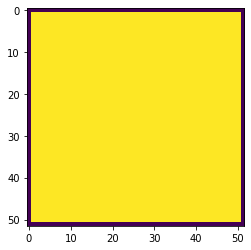

In [213]:
obstacleRadius = 0.15
overRelaxation = 1.9
dt = 1.0 / 60.0
numIters = 40

res = 50

domainHeight = 1.0
domainWidth = domainHeight
h = domainHeight / res
numX = int(domainWidth / h)
numY = int(domainHeight / h)

density = 1000.0

f = Fluid(density, numX, numY, h)
f.s.fill(1)
f.s[0, :] = 0  # top row
f.s[-1, :] = 0  # bottom row
f.s[:, 0] = 0  # left column
f.s[:, -1] = 0  # right column

plt.imshow(f.s, interpolation='nearest')
plt.show()
gravity = -9.81
showPressure = True


In [ ]:
for _ in range(10):
  f.simulate(1.0,-9.8,40)
  plt.show()